# LJ data

## Analysis of Monte-Carlo simulation data of a Lennard-Jones fluid

## The data is obtained with my Julia MC code that can be found here:

(https://github.com/mikhail-a-ivanov/ML-IMC)

## The following data will be used as a training data for my first ML-IMC network

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image

In [10]:
HOME = ! pwd
HOME = HOME[0]

In [11]:
cd {HOME}

/largedisk/LJ


## 1. Benchmarks

I will start with analysing some of the benchmarks I ran on alkluster.

In [12]:
cd {HOME}/mmkluster-benchmarks

/largedisk/LJ/mmkluster-benchmarks


In [13]:
! cat runmc-bench.sh

#!/bin/bash -l
#SBATCH -J mc
#SBATCH -t 24:00:00
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=40
#SBATCH -e mc.err
#SBATCH --exclusive
#SBATCH --mail-type=ALL
#SBATCH --mail-user=mikhail.ivanov@mmk.su.se 

ncores=(1 2 4 8 10 20 40)
for np in ${ncores[@]}; do
        julia -p $np mcLJ-run.jl LJ-init.in > p$np.out
done


In [14]:
! grep seconds *out

p10.out:Walltime: 32 seconds, 462 milliseconds
p1.out:Walltime: 27 seconds, 78 milliseconds
p20.out:Walltime: 39 seconds, 470 milliseconds
p2.out:Walltime: 25 seconds, 703 milliseconds
p40.out:Walltime: 36 seconds, 222 milliseconds
p4.out:Walltime: 26 seconds, 538 milliseconds
p8.out:Walltime: 31 seconds, 967 milliseconds


The scaling looks pretty good! Running on 40 MC simulations on 40 CPU cores instead of 1 simulation on 1 core is only around 30% slower.

# 2. Analysis

In [122]:
cd {HOME}/LJ-data

/largedisk/LJ/LJ-data


Slurm script for running the simulation:

In [123]:
! cat runmc.sh

#!/bin/bash -l
#SBATCH -J mc
#SBATCH -t 168:00:00
#SBATCH --nodes=1
#SBATCH --ntasks-per-node=40
#SBATCH -e mc.err
#SBATCH --exclusive

julia -p 40 mcLJ-run.jl LJ-init.in > p40.out


In [28]:
! cat p40.out

Running MC simulation on 40 rank(s)...

Starting at: 2022-03-08T17:30:06.748
Mean acceptance ratio = 0.416
Stopping at: 2022-03-08T21:37:29.172

Walltime: 4 hours, 7 minutes, 22 seconds, 424 milliseconds


Input parameters:

In [27]:
! cat LJ-init.in

# System
latticePoints = 10        # Number of LJ lattice points

# Forcefield
atommass      = 39.792    # [amu]
sigma         = 3.405     # [Å]
epsilon       = 119.8     # ϵ/kB [K]

# Conditions
temperature   = 95.0      # [K]
density       = 1374.0    # [kg/m3]

# Monte Carlo parameters
delta         = 0.75      # Max displacement [Å]
steps         = 5E8       # Total number of MC steps
Eqsteps       = 1E7       # Equilibration MC steps

# RDF parameters
binWidth      = 0.025     # [Å]
Nbins         = 600       # number of bins

# Output control
xyzout        = 1E8       # XYZ output frequency
outfreq       = 5E5       # Output frequency
outlevel      = 3         # Output level (0: no output, 1: +RDF, 2: +energies, 3: +trajectories)


Number of MC steps:
- 40 workers
- 500M total steps, 10M equilibration
- total production steps: (500M - 10M) * 40 = 19600M steps

Energy analysis:

In [104]:
E = np.genfromtxt("energies-p001.dat")

In [105]:
steps = np.arange(0, 5.005E8, 5E5)

In [106]:
slope, intercept = np.polyfit(steps[20:], E[20:], deg=1)

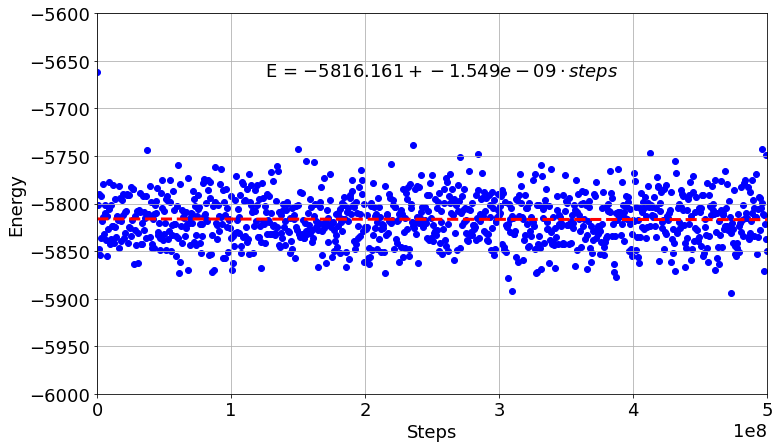

In [107]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(12,7))
plt.plot(steps, (slope*steps + intercept), 'r--', lw=3)
plt.scatter(steps, E, color='blue')
plt.xlabel('Steps')
plt.ylabel('Energy')
plt.xlim(0, 5E8)
plt.ylim(-6000, -5600)
plt.text(0.25*np.amax(steps), np.mean(E)+150, f"E = ${intercept:.3f} + {slope:.3e} \cdot steps$")
plt.grid()
plt.savefig("Energies.pdf")
plt.show()

Conversion to eV for comparison:

In [40]:
kB = 1.38064852E-23 # [J/K]
eps = 119.8*kB # [J]; original value in ϵ/kB [K]
ev_to_J = 1.602E-19 # [J]

In [41]:
print(f'Average energy: {np.mean(E[20:])*eps/ev_to_J:.3f} eV')

Average energy: -60.054 eV


I get the exact same energy as with my pyLJ code!

Now I will compare the average energies from each worker:

In [109]:
energyfiles = ! ls energies*

In [113]:
energies = []
for file in energyfiles:
    E = np.genfromtxt(file)
    energies.append(np.mean(E[20:]))

energies = np.array(energies)

In [118]:
Emean = np.mean(energies)
Eerror = np.std(energies)/np.sqrt(len(energies))

In [121]:
print(f"Average energy: {Emean:.4f} +/- {Eerror:.4f} reduced units")

Average energy: -5816.1972 +/- 0.1173 reduced units


It's great to see that the resulting energies are different for each worker but very close still.

Finally, RDF data:

In [42]:
rdf_data = np.genfromtxt("rdf-mean-p40.dat").T

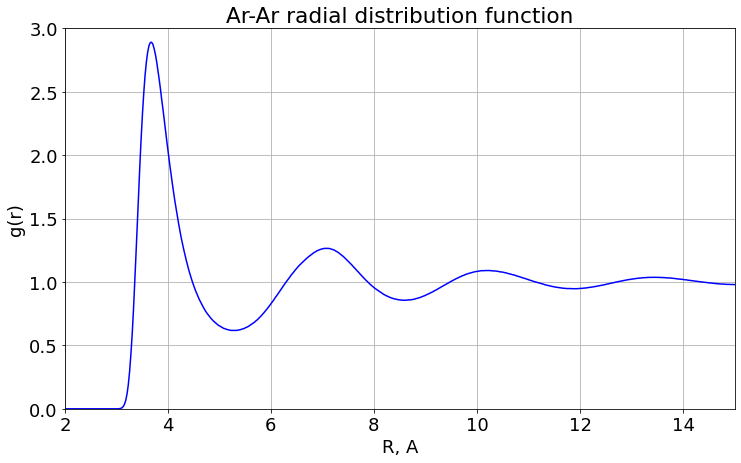

In [51]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(12,7))
plt.plot(rdf_data[0], rdf_data[1], color='blue')
plt.xlabel('R, A')
plt.ylabel('g(r)')
plt.xlim(2, 15)
plt.ylim(0, 3)
plt.title("Ar-Ar radial distribution function")
plt.grid()
plt.savefig("RDF.pdf")
plt.show()

The RDF looks good! It is also very smooth.

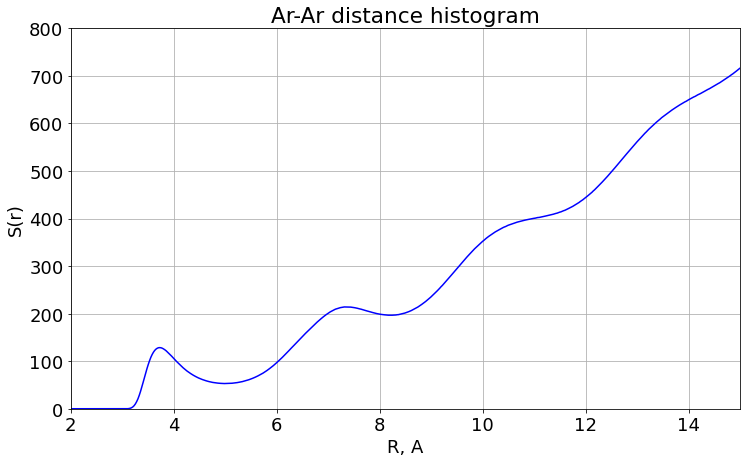

In [52]:
plt.rcParams.update({'font.size': 18})
plt.figure(figsize=(12,7))
plt.plot(rdf_data[0], rdf_data[2], color='blue')
plt.xlabel('R, A')
plt.ylabel('S(r)')
plt.xlim(2, 15)
plt.ylim(0, 800)
plt.title("Ar-Ar distance histogram")
plt.grid()
plt.savefig("Histogram.pdf")
plt.show()